In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as np
import pandas as pd
import gzbuilder_analysis.parsing as pg
from scipy.optimize import minimize
from gzbuilder_analysis.rendering.jax.spiral import vmap_polyline_distance
from gzbuilder_analysis.rendering import jax2
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')

In [4]:
subject_id = 20902040

In [5]:
diff_data = diff_data_df.loc[subject_id]
psf = diff_data['psf']
target = np.asarray(diff_data['galaxy_data'].data)
mask = np.asarray(diff_data['galaxy_data'].mask)
sigma = np.asarray(diff_data['sigma_image'].data)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [103]:
agg_res = pd.read_pickle(f'output_files/aggregation_results/{subject_id}.pkl.gz')

In [7]:
m = pg.from_pandas(agg_res.params)
new_model = jax2.restructure_model(m)
new_model['spiral'].pop('points')
params = jax2.to_reparametrization(new_model)
points = [arm.reprojected_log_spiral for arm in agg_res.spiral_arms]
errs = pg.from_pandas(agg_res.errors.reindex_like(agg_res.params).replace(np.nan, np.inf))
errs = jax2.restructure_model(errs)
errs['spiral'].pop('points')
model_sigma = jax2.get_errors_in_reparmetrization(errs)

In [53]:
params

{'bar': {'c': DeviceArray(2., dtype=float64),
  'frac': DeviceArray(0.01816764, dtype=float64),
  'mux': DeviceArray(130.4507896, dtype=float64),
  'muy': DeviceArray(126.8407959, dtype=float64),
  'n': DeviceArray(1., dtype=float64),
  'q': DeviceArray(0.36805175, dtype=float64),
  'roll': DeviceArray(2.90136117, dtype=float64),
  'scale': DeviceArray(0.19237365, dtype=float64)},
 'bulge': {'c': 2.0,
  'frac': DeviceArray(0.01291912, dtype=float64),
  'mux': DeviceArray(130.01917347, dtype=float64),
  'muy': DeviceArray(126.36071487, dtype=float64),
  'n': DeviceArray(1., dtype=float64),
  'q': DeviceArray(0.52535749, dtype=float64),
  'roll': DeviceArray(3.02955479, dtype=float64),
  'scale': DeviceArray(0.1144037, dtype=float64)},
 'disk': {'L': DeviceArray(590.08461735, dtype=float64),
  'Re': DeviceArray(15.71401937, dtype=float64),
  'c': 2.0,
  'mux': DeviceArray(129.61708134, dtype=float64),
  'muy': DeviceArray(127.18448237, dtype=float64),
  'n': 1.0,
  'q': DeviceArray(0.743

In [56]:
agg_res.spiral_arms

In [8]:
n = 5 # oversampling factor
shape = target.shape

x = np.arange(shape[1], dtype=np.float64)
y = np.arange(shape[0], dtype=np.float64)
cx, cy = np.meshgrid(x, y)
x_super = np.linspace(0.5 / n - 0.5, shape[1] - 0.5 - 0.5 / n, shape[1] * n)
y_super = np.linspace(0.5 / n - 0.5, shape[0] - 0.5 - 0.5 / n, shape[0] * n)
cx_super, cy_super = np.meshgrid(x_super, y_super)

In [79]:
from gzbuilder_analysis.rendering.jax.sersic import sersic, _b, sersic_ltot, sersic_I

In [81]:
def get_fraction(comp_l, disk_l):
    return comp_l / (disk_l + comp_l)


In [89]:
model.loc['I', 'disk'] = 1.0

In [108]:
ALL_PARAMS = [
    'mux', 'muy', 'Re', 'q', 'roll', 'L', 'c', 'n',
    'scale', 'frac',
    'I', 'spread', 'falloff', 'A', 'phi', 'tmin', 'dt'
]

disk = agg_res.params['disk']
bulge = agg_res.params['bulge']
bar = agg_res.params['bar']
spirals = pd.DataFrame([
    agg_res.params[f'spiral{i}']
    for i in range(len(agg_res.spiral_arms))
])

model = pd.DataFrame([], #index=ALL_PARAMS,
                     columns=['disk', 'bulge', 'bar', 'spiral'],
                    dtype=np.float64)
model['disk'] = disk.copy()
model.loc['L', 'disk'] = sersic_ltot(disk.I, disk.Re, 1.0)
model.loc['I', 'disk'] = np.nan

model['bulge'] = bulge.copy()
model.loc['scale', 'bulge'] = bulge.Re / disk.Re
bulge_l = sersic_ltot(bulge.I, bulge.Re, bulge.n)
model.loc['frac', 'bulge'] = get_fraction(bulge_l, model['disk']['L'])
model.loc['I', 'bulge'] = np.nan
model.loc['Re', 'bulge'] = np.nan

model['bar'] = bar.copy()
model.loc['scale', 'bar'] = bar.Re / bar.Re
bar_l = sersic_ltot(bar.I, bar.Re, bar.n)
model.loc['frac', 'bar'] = get_fraction(bar_l, model['disk']['L'])
model.loc['I', 'bar'] = np.nan
model.loc['Re', 'bar'] = np.nan

for i in range(len(spirals)):
    model.loc[f'I.{i}', 'spiral'] = spirals['I'].iloc[i]
    model.loc[f'falloff.{i}', 'spiral'] = spirals['falloff'].iloc[i]
    model.loc[f'spread.{i}', 'spiral'] = spirals['spread'].iloc[i]
    model.loc[f'A.{i}', 'spiral'] = agg_res.spiral_arms[i].A
    model.loc[f'phi.{i}', 'spiral'] = agg_res.spiral_arms[i].pa * agg_res.spiral_arms[i].chirality
    model.loc[f't_min.{i}', 'spiral'] = agg_res.spiral_arms[i].t_predict.min()
    model.loc[f'dt.{i}', 'spiral'] = agg_res.spiral_arms[i].t_predict.max() - model.loc[f't_min.{i}', 'spiral']
# model.loc['falloff', 'spiral'] = spirals['falloff'].values
# model.loc['spread', 'spiral'] = spirals['spread'].values

model.unstack().dropna()

        parameter
disk    mux          129.617081
        muy          127.184482
        Re            15.714019
        q              0.743224
        roll           2.799301
        n              1.000000
        c              2.000000
        L            590.084617
bulge   mux          130.019173
        muy          126.360715
        q              0.525357
        roll           3.029555
        n              1.000000
        c              2.000000
        scale          0.114404
        frac           0.012919
bar     mux          130.450790
        muy          126.840796
        q              0.368052
        roll           2.901361
        n              1.000000
        c              2.000000
        scale          1.000000
        frac           0.018168
spiral  I.0            0.100000
        falloff.0      1.000000
        spread.0       0.500000
        A.0            9.885009
        phi.0         14.540627
        t_min.0        1.791734
        dt.0          

In [107]:
def comp_bool_indexing(df):
    """Quickly convert a DataFrame to a dictionary, removing any NaNs
    """
    return {k: v[v.notna()].to_dict() for k, v in df.items()}

comp_bool_indexing(model)

{'disk': {'mux': 129.6170813371778,
  'muy': 127.1844823719904,
  'Re': 15.714019373862985,
  'q': 0.7432242100547148,
  'roll': 2.799300503403965,
  'n': 1.0,
  'c': 2.0,
  'L': 590.0846173529989},
 'bulge': {'mux': 130.01917347341623,
  'muy': 126.36071487006105,
  'q': 0.5253574864290562,
  'roll': 3.0295547922354253,
  'n': 1.0,
  'c': 2.0,
  'scale': 0.11440370060127447,
  'frac': 0.012919118616288696},
 'bar': {'mux': 130.4507896043422,
  'muy': 126.8407958952581,
  'q': 0.3680517468379793,
  'roll': 2.901361170990977,
  'n': 1.0,
  'c': 2.0,
  'scale': 1.0,
  'frac': 0.018167639210268042},
 'spiral': {'I.0': 0.1,
  'falloff.0': 1.0,
  'spread.0': 0.5,
  'A.0': 9.885008757268894,
  'phi.0': 14.540626946724476,
  't_min.0': 1.7917341469488985,
  'dt.0': 4.386107429972335,
  'I.1': 0.1,
  'falloff.1': 1.0,
  'spread.1': 0.5,
  'A.1': 20.24485531122746,
  'phi.1': 18.151983008667745,
  't_min.1': -1.9957077095618276,
  'dt.1': 4.533563754850559}}

In [99]:
[f'I.{i}' for i in range(len(spirals))]

['I.0', 'I.1']

In [94]:
pd.DataFrame(spiral)['I']

parameter,I,spread,falloff
model,0.1,0.5,1.0
model,0.1,0.5,1.0


In [9]:
try:
    distances = np.stack([
        vmap_polyline_distance(p, cx, cy)
        for p in points
    ], axis=-1)
except ValueError:
    distances = np.array([], dtype=np.float64)

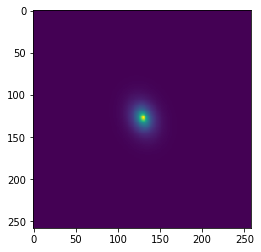

In [10]:
plt.imshow(jax2.render(cx_super, cy_super, params, distances, psf))

In [49]:
from jax import jacfwd

In [ ]:
@jit
def logsp(min_t=0, delta_t=2*np.pi, A=0.1, phi=10, q=0, roll=0, mux=0, muy=0, N=1000, **kwargs):
    theta = np.linspace(min_t, min_t + delta_t, N)
    Rls = A * np.exp(np.tan(np.deg2rad(phi)) * theta)
    rot_matrix = np.array((
        (np.cos(-roll), np.sin(-roll)),
        (-np.sin(-roll), np.cos(-roll))
    ))
    return np.dot(
        rot_matrix,
        Rls * np.array((q * np.cos(theta), np.sin(theta)))
    ).T + np.array((mux, muy))

In [46]:
def optimization_step(p, p0, x, y, agg_res, psf, target, sigma, mask, mu_params, sigma_params):
    p = jax2.from_1d(
        pd.Series(p, index=p0.index)
    ).unstack().T
    params = jax2.comp_bool_indexing(p)
    kw = dict(
        centre=np.asarray((params['disk']['mux'], params['disk']['muy'])),
        phi=params['disk']['roll'],
        ba=params['disk']['q'],
    )
    points = [arm.modify_disk(**kw) for arm in agg_res.spiral_arms]
    try:
        distances = np.stack([
            vmap_polyline_distance(p, jax2.downsample(x)[:, :, 0], jax2.downsample(y)[:, :, 0])
            for p in points
        ], axis=-1)
    except ValueError:
        distances = np.array([], dtype=np.float64)
    r = jax2.render(x, y, params, distances, psf)
    render_delta = (r - target) / sigma
    param_delta = np.concatenate([
        np.reshape(np.asarray(params[k][j] - mu_params[k][j]), -1) / sigma_params[k][j]
        for k in params for j in params[k]
    ])
    return -jax2.norm_nnlf(np.concatenate((render_delta.ravel(), param_delta)))
#     return jax2.do_calc(x, y, params, distances, psf, target, sigma, mask,
#                    mu_params, sigma_params)

In [50]:
jacf = jacfwd(lambda p: optimization_step(p, *args))

In [ ]:
jac_minim = make_jac_func(*args[1:])
_jacf = lambda p, *args: _jac(jac_minim, p, *args)


In [37]:
original_p = pd.DataFrame(params).unstack().dropna()
p0 = jax2.to_1d(original_p)

In [38]:
args = (p0, cx_super, cy_super, agg_res, psf, target, sigma, mask, params, model_sigma)

In [47]:
optimization_step(p0, *args)

DeviceArray(457552.78069931, dtype=float64)

And now time its execution:

In [40]:
%timeit optimization_step(p0, *args)

8.34 s ± 530 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# orignal_p = pd.DataFrame(model).unstack().dropna()
# p0 = to_1d(orignal_p)

# args = (p0, cx_super, cy_super, distances, psf, target, sigma, mask, model, model_sigma)

# jac_minim = make_jac_func(*args[1:])
# _jacf = lambda p, *args: _jac(jac_minim, p, *args)

# with tqdm(leave=True) as pbar:
#     def update_bar(*args):
#             pbar.update(1)
#     res = minimize(
#         _func, p0.values, args=args,
#         jac=_jacf,
#         callback=update_bar,
#         options=dict(maxiter=100),
#     )

# final_params = comp_bool_indexing(
#     from_1d(pd.Series(res['x'], index=p0.index)).unstack().T
# )